## RAG using Cloud APIs

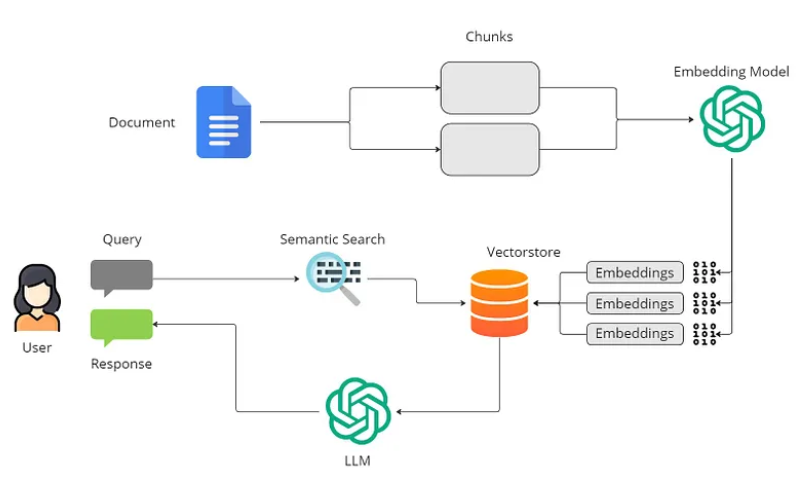

RAG Application using only Free resources

1.   Using Llama Parse to parse the documents *(Instead can use python libraries to read PDF and word documents)*
2.   Qdrant as Vector database *(Can use other vector store like Chroma)*
3.   Huggingface embedding models *(Can use other embedding models)*
4.   Google AI Sutdio Gemini model as LLM *(Can connect to other LLMs)*
5.   Llama Index framework to execute RAG



## 1. Install Packages
Install Google AI Sutdio related packages and llamaindex gemini package

In [ ]:
!pip install -U -q "google-generativeai>=0.7.2" # Install the Python SDK
!pip install llama-index-llms-gemini   #llama-index gemini package


Install packages related to llama-index, qdrant and huggingface embedding models

In [ ]:
!pip install llama-index-core llama-parse llama-index-readers-file python-dotenv

!pip install qdrant-client

!pip install nest-asyncio

!pip install llama-index

!pip install llama-index-embeddings-huggingface

!pip install llama-index-vector-stores-qdrant


## 2. Set up API Keys
Need to create below secrets in Google colabs
Get Free API keys from below websites.
1. [Google AI Studio](https://ai.google.dev/aistudio)
2. [HuggingFace](https://huggingface.co/)
3. [Qdrant](https://qdrant.tech/)
4. [LlamaParse](https://cloud.llamaindex.ai/login)
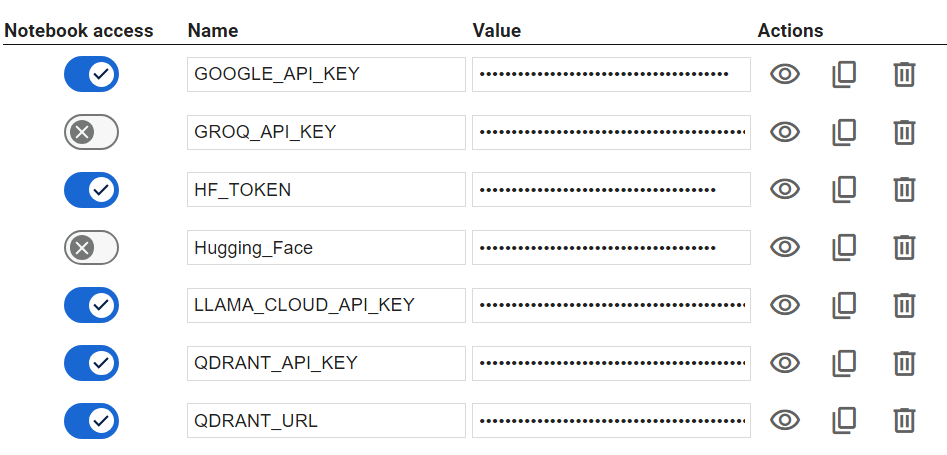

In [ ]:
## Google AI Studio API Key
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

## Qdrant URL and API Keys
qdrant_url = userdata.get("QDRANT_URL")
qdrant_api_key = userdata.get("QDRANT_API_KEY")

## Llama cloud API Key
llamaparse_api_key = userdata.get("LLAMA_CLOUD_API_KEY")

## 3. Mount Google drive.
Documents are placed in Google drive for parsing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 4. Parse Documents using LlamaParse
Documents are placed in Google Drive

In [ ]:
from google.colab import userdata

from llama_parse import LlamaParse
import nest_asyncio;
nest_asyncio.apply()

# load the document and parse it using LlamaParse api
parse_documents = LlamaParse(api_key=llamaparse_api_key, result_type="markdown").load_data("/content/drive/MyDrive/Meta-FS.pdf")

# Need to run these blocks again along with blocks to persist new documents

Started parsing the file under job_id 48f5b41f-3aa9-45f2-b413-338bb4cdb7da


## 5. Store the documents embedding in Vector database
Embeddings from Parsed documents are created using HuggingFace sentence transformers model

In [ ]:
import qdrant_client

client = qdrant_client.QdrantClient(api_key=qdrant_api_key, url=qdrant_url)

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Use Sentence Transformers embedding model from Hugging face
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2")

In [ ]:

# 1. Initialize the QdrantVectorStore
vector_store = QdrantVectorStore(client=client, collection_name='llama_parse_qdrant_rag')

# 2. Create StorageContext with the vector store
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 3. To build the index with parsed documents into the vector store
index = VectorStoreIndex.from_documents(documents=parse_documents, storage_context=storage_context, show_progress=True, embed_model=embed_model)

## 6. Retrive the documents embedding from Vector database


In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Assuming you have your qdrant_client initialized as 'client'

# 1. Initialize the QdrantVectorStore, pointing to your existing collection
vector_store = QdrantVectorStore(
    client=client, collection_name='llama_parse_qdrant_rag'
)

# 2. Create StorageContext with the loaded vector store
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# 3. Initialize VectorStoreIndex using from_documents
# This should load any existing documents in Qdrant (assuming index was built earlier)
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-mpnet-base-v2")

oldIndex = VectorStoreIndex.from_documents(documents=[], storage_context=storage_context, embed_model=embed_model)

## 7. Run user query using Gemini model

In [ ]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings

# Using Google Gemini as our LLM
llm = Gemini(api_key=GOOGLE_API_KEY)
Settings.embed_model = embed_model
Settings.llm = llm

In [ ]:
query_engine = oldIndex.as_query_engine()

query = "Total Cost of sales  and give its break down. Provided this in tabular format"
response = query_engine.query(query)
print(response)

| | Three Months Ended December 31, | Twelve Months Ended December 31, |
|---|---|---|
| | 2023 | 2022 |
| Cost of Revenue | $7,695 | $8,336 |
| Research and Development | $10,517 | $9,771 |
| Marketing and Sales | $3,226 | $4,574 |
| General and Administrative | $2,289 | $3,085 |
| **Total Costs and Expenses** | **$23,727** | **$25,766** |
| **Total Costs of Sales** | **$23,727** | **$25,766** | 
| **Breakdown** | **Cost of Revenue, Research and Development, Marketing and Sales, General and Administrative** | **Cost of Revenue, Research and Development, Marketing and Sales, General and Administrative** | 



In [ ]:
query_engine = oldIndex.as_query_engine()
query = "What are Total Cost of sales for Meta for year 2023 and 2022 "
response = query_engine.query(query)
print(response)

The total cost of revenue for Meta in 2023 was $25,959 million and $25,249 million in 2022. 



In [ ]:
query_engine = oldIndex.as_query_engine()
query = "What are Total Cost of revenue for Meta for year 2023 and 2022 "
response = query_engine.query(query)
print(response)

The total cost of revenue for Meta in 2023 was $25,959 million and $25,249 million in 2022. 



## Optional: Run your own LLM by downloading it from HuggingFace

In [ ]:
!pip install llama-index-llms-llama-cpp

In [ ]:
!pip install torch

In [ ]:
import torch

from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.llms.llama_cpp.llama_utils import messages_to_prompt, completion_to_prompt
llm = LlamaCPP(
 # You can pass in the URL to a GGML model to download it automatically
 # model_url='https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf',
 model_url='https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf',
 # optionally, you can set the path to a pre-downloaded model instead of model_url
 model_path=None,
 temperature=0.1,
 max_new_tokens=256,
 # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
 context_window=4096,
 # kwargs to pass to __call__()
 generate_kwargs={},
 # kwargs to pass to __init__()
 # set to at least 1 to use GPU
 model_kwargs={"n_gpu_layers": -1},
 # transform inputs into Llama2 format
 messages_to_prompt=messages_to_prompt,
 completion_to_prompt=completion_to_prompt,
 verbose=True,
)

In [ ]:
response = llm.complete("How is weather today")
print(response)